In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

In [3]:
from model import Net, Net1
from train import train
from test import test
from config import ModelConfig

In [4]:
# View model config
args = ModelConfig()
args.print_config()

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.05,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}


In [5]:
transform = transforms.Compose(
    [#transforms.ToPILImage(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)),
     transforms.RandomAffine((-5,5), translate=(0.1,0.1), scale=(0.9,1.1), shear=None, resample=False, fill=(0.4919, 0.4827, 0.4472))
    ])

trainset = torchvision.datasets.CIFAR10(root='./../data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./../data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

/home/lebeast/miniconda3/envs/pytorch19/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1343: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


torch.Size([4, 3, 32, 32])
 ship  bird   cat   dog


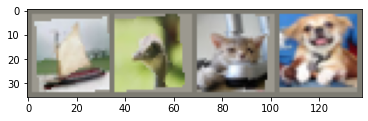

In [6]:
# functions to show an image

def imshow(img):
    #(0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)
    img[0] = img[0]*0.2470 + 0.4919
    img[1] = img[1]*0.2434 + 0.4827
    img[2] = img[2]*0.2616 + 0.4472
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 12]

def training_curves(history):
  plt.figure(1)
  plt.suptitle("Combined Training Curves", fontsize=28)

  plt.subplot(2,2, 1)
  for i in history:
    plt.plot(np.array(history[i]['train_loss']), label=i)
  #plt.plot(np.array(hist_train_acc), 'r')
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training loss per batch")

  plt.subplot(2,2, 2)
  for i in history:
    plt.plot(np.array(history[i]['test_loss']), label=i)
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test loss per batch")

  plt.subplot(2,2, 3)
  for i in history:
    plt.plot(np.array(history[i]['train_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training accuracy per batch")

  plt.subplot(2,2, 4)
  for i in history:
    plt.plot(np.array(history[i]['test_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test accuracy per epoch")


In [8]:
temp = Net(args).to(device)
summary(temp, 
        (3, 32, 32),)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,864
             ReLU-14           [-1, 64,

/home/lebeast/miniconda3/envs/pytorch19/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
# Input parameters for the model
EPOCHS = 80
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run model for first 20 epochs with high rate, and half it thereafter
model = Net(args).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Net5'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.7949850559234619 Batch_id=12499 Accuracy=36.28: 100%|██████████| 12500/12500 [00:49<00:00, 252.73it/s] 

length of Average loss 12500, length of Average accuracy 12500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3513, Accuracy: 5012/10000 (50.12%)

EPOCH: 2


Loss=1.4550597667694092 Batch_id=12499 Accuracy=49.94: 100%|██████████| 12500/12500 [00:49<00:00, 250.67it/s] 

length of Average loss 25000, length of Average accuracy 25000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3055, Accuracy: 5931/10000 (59.31%)

EPOCH: 3


Loss=1.272787094116211 Batch_id=12499 Accuracy=56.24: 100%|██████████| 12500/12500 [00:49<00:00, 250.94it/s]  

length of Average loss 37500, length of Average accuracy 37500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2902, Accuracy: 6454/10000 (64.54%)

EPOCH: 4


Loss=0.7059026956558228 Batch_id=12499 Accuracy=60.16: 100%|██████████| 12500/12500 [00:49<00:00, 250.35it/s]  

length of Average loss 50000, length of Average accuracy 50000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2497, Accuracy: 6727/10000 (67.27%)

EPOCH: 5


Loss=0.4125215709209442 Batch_id=12499 Accuracy=61.58: 100%|██████████| 12500/12500 [00:49<00:00, 251.39it/s]  

length of Average loss 62500, length of Average accuracy 62500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2599, Accuracy: 6728/10000 (67.28%)

EPOCH: 6


Loss=0.13716140389442444 Batch_id=12499 Accuracy=65.16: 100%|██████████| 12500/12500 [00:49<00:00, 250.82it/s] 

length of Average loss 75000, length of Average accuracy 75000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2403, Accuracy: 6951/10000 (69.51%)

EPOCH: 7


Loss=1.1753674745559692 Batch_id=12499 Accuracy=66.24: 100%|██████████| 12500/12500 [00:49<00:00, 252.12it/s]  


length of Average loss 87500, length of Average accuracy 87500

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2354, Accuracy: 7069/10000 (70.69%)

EPOCH: 8


Loss=1.5179858207702637 Batch_id=12499 Accuracy=67.91: 100%|██████████| 12500/12500 [00:49<00:00, 253.40it/s]  


length of Average loss 100000, length of Average accuracy 100000

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2440, Accuracy: 7215/10000 (72.15%)

EPOCH: 9


Loss=1.2496602535247803 Batch_id=12499 Accuracy=69.02: 100%|██████████| 12500/12500 [00:49<00:00, 254.15it/s]  

length of Average loss 112500, length of Average accuracy 112500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2189, Accuracy: 7317/10000 (73.17%)

EPOCH: 10


Loss=0.34561142325401306 Batch_id=12499 Accuracy=70.37: 100%|██████████| 12500/12500 [00:49<00:00, 254.29it/s] 

length of Average loss 125000, length of Average accuracy 125000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2259, Accuracy: 7384/10000 (73.84%)

EPOCH: 11


Loss=2.4276108741760254 Batch_id=12499 Accuracy=71.32: 100%|██████████| 12500/12500 [00:48<00:00, 255.26it/s]   

length of Average loss 137500, length of Average accuracy 137500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2089, Accuracy: 7469/10000 (74.69%)

EPOCH: 12


Loss=0.8058174848556519 Batch_id=12499 Accuracy=71.95: 100%|██████████| 12500/12500 [00:48<00:00, 255.39it/s]  

length of Average loss 150000, length of Average accuracy 150000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2110, Accuracy: 7568/10000 (75.68%)

EPOCH: 13


Loss=0.870463490486145 Batch_id=12499 Accuracy=72.25: 100%|██████████| 12500/12500 [00:49<00:00, 253.00it/s]   

length of Average loss 162500, length of Average accuracy 162500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1865, Accuracy: 7627/10000 (76.27%)

EPOCH: 14


Loss=0.5607393383979797 Batch_id=12499 Accuracy=69.95: 100%|██████████| 12500/12500 [00:49<00:00, 253.40it/s]  

length of Average loss 175000, length of Average accuracy 175000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2700, Accuracy: 7255/10000 (72.55%)

EPOCH: 15


Loss=0.14383916556835175 Batch_id=12499 Accuracy=72.56: 100%|██████████| 12500/12500 [00:48<00:00, 255.29it/s] 

length of Average loss 187500, length of Average accuracy 187500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1921, Accuracy: 7561/10000 (75.61%)

EPOCH: 16


Loss=0.1574566513299942 Batch_id=12499 Accuracy=73.52: 100%|██████████| 12500/12500 [00:49<00:00, 254.27it/s]   

length of Average loss 200000, length of Average accuracy 200000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3037, Accuracy: 7539/10000 (75.39%)

EPOCH: 17


Loss=0.3852217495441437 Batch_id=12499 Accuracy=74.21: 100%|██████████| 12500/12500 [00:49<00:00, 253.52it/s]   

length of Average loss 212500, length of Average accuracy 212500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2365, Accuracy: 7608/10000 (76.08%)

EPOCH: 18


Loss=1.337711215019226 Batch_id=12499 Accuracy=73.60: 100%|██████████| 12500/12500 [00:49<00:00, 253.54it/s]   


length of Average loss 225000, length of Average accuracy 225000

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1834, Accuracy: 7679/10000 (76.79%)

EPOCH: 19


Loss=0.2157922387123108 Batch_id=12499 Accuracy=75.05: 100%|██████████| 12500/12500 [00:49<00:00, 254.54it/s]  


length of Average loss 237500, length of Average accuracy 237500

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1938, Accuracy: 7758/10000 (77.58%)

EPOCH: 20


Loss=0.5535035133361816 Batch_id=12499 Accuracy=75.18: 100%|██████████| 12500/12500 [00:49<00:00, 252.44it/s]  

length of Average loss 250000, length of Average accuracy 250000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1966, Accuracy: 7584/10000 (75.84%)

EPOCH: 21


Loss=0.9892517924308777 Batch_id=12499 Accuracy=77.70: 100%|██████████| 12500/12500 [00:48<00:00, 256.60it/s]   

length of Average loss 262500, length of Average accuracy 262500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2172, Accuracy: 7339/10000 (73.39%)

EPOCH: 22


Loss=0.5971106886863708 Batch_id=12499 Accuracy=76.65: 100%|██████████| 12500/12500 [00:47<00:00, 265.39it/s]  

length of Average loss 275000, length of Average accuracy 275000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1753, Accuracy: 8026/10000 (80.26%)

EPOCH: 23


Loss=0.46185532212257385 Batch_id=12499 Accuracy=78.32: 100%|██████████| 12500/12500 [00:47<00:00, 264.57it/s]  

length of Average loss 287500, length of Average accuracy 287500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2118, Accuracy: 7928/10000 (79.28%)

EPOCH: 24


Loss=0.5884620547294617 Batch_id=12499 Accuracy=78.39: 100%|██████████| 12500/12500 [00:47<00:00, 263.51it/s]   

length of Average loss 300000, length of Average accuracy 300000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2115, Accuracy: 7883/10000 (78.83%)

EPOCH: 25


Loss=0.2434631735086441 Batch_id=12499 Accuracy=78.99: 100%|██████████| 12500/12500 [00:47<00:00, 264.40it/s]   

length of Average loss 312500, length of Average accuracy 312500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1716, Accuracy: 7975/10000 (79.75%)

EPOCH: 26


Loss=0.0555013045668602 Batch_id=12499 Accuracy=78.93: 100%|██████████| 12500/12500 [00:46<00:00, 266.77it/s]   

length of Average loss 325000, length of Average accuracy 325000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1727, Accuracy: 7973/10000 (79.73%)

EPOCH: 27


Loss=0.45348045229911804 Batch_id=12499 Accuracy=79.09: 100%|██████████| 12500/12500 [00:47<00:00, 264.53it/s]  

length of Average loss 337500, length of Average accuracy 337500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2377, Accuracy: 7992/10000 (79.92%)

EPOCH: 28


Loss=1.6672966480255127 Batch_id=12499 Accuracy=79.19: 100%|██████████| 12500/12500 [00:47<00:00, 263.05it/s]   

length of Average loss 350000, length of Average accuracy 350000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2062, Accuracy: 8048/10000 (80.48%)

EPOCH: 29


Loss=0.4670094847679138 Batch_id=12499 Accuracy=79.23: 100%|██████████| 12500/12500 [00:47<00:00, 263.68it/s]   

length of Average loss 362500, length of Average accuracy 362500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3489, Accuracy: 8003/10000 (80.03%)

EPOCH: 30


Loss=0.7357409596443176 Batch_id=12499 Accuracy=79.44: 100%|██████████| 12500/12500 [00:47<00:00, 263.89it/s]   

length of Average loss 375000, length of Average accuracy 375000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.8291, Accuracy: 7958/10000 (79.58%)

EPOCH: 31


Loss=0.38187044858932495 Batch_id=12499 Accuracy=79.62: 100%|██████████| 12500/12500 [00:47<00:00, 264.26it/s]  

length of Average loss 387500, length of Average accuracy 387500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1675, Accuracy: 8034/10000 (80.34%)

EPOCH: 32


Loss=0.26276087760925293 Batch_id=12499 Accuracy=79.74: 100%|██████████| 12500/12500 [00:47<00:00, 262.79it/s]  

length of Average loss 400000, length of Average accuracy 400000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3971, Accuracy: 8087/10000 (80.87%)

EPOCH: 33


Loss=0.5864397883415222 Batch_id=12499 Accuracy=79.95: 100%|██████████| 12500/12500 [00:47<00:00, 265.20it/s]   

length of Average loss 412500, length of Average accuracy 412500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1995, Accuracy: 8028/10000 (80.28%)

EPOCH: 34


Loss=0.8745343089103699 Batch_id=12499 Accuracy=80.04: 100%|██████████| 12500/12500 [00:47<00:00, 264.32it/s]   

length of Average loss 425000, length of Average accuracy 425000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1455, Accuracy: 8152/10000 (81.52%)

EPOCH: 35


Loss=0.6843957901000977 Batch_id=12499 Accuracy=80.15: 100%|██████████| 12500/12500 [00:47<00:00, 264.31it/s]   

length of Average loss 437500, length of Average accuracy 437500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1516, Accuracy: 8108/10000 (81.08%)

EPOCH: 36


Loss=1.6059925556182861 Batch_id=12499 Accuracy=79.70: 100%|██████████| 12500/12500 [00:47<00:00, 264.15it/s]   

length of Average loss 450000, length of Average accuracy 450000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1607, Accuracy: 7991/10000 (79.91%)

EPOCH: 37


Loss=0.5769435167312622 Batch_id=12499 Accuracy=79.35: 100%|██████████| 12500/12500 [00:47<00:00, 264.16it/s]   

length of Average loss 462500, length of Average accuracy 462500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2566, Accuracy: 7938/10000 (79.38%)

EPOCH: 38


Loss=0.013910905458033085 Batch_id=12499 Accuracy=80.26: 100%|██████████| 12500/12500 [00:47<00:00, 262.29it/s] 

length of Average loss 475000, length of Average accuracy 475000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2417, Accuracy: 7999/10000 (79.99%)

EPOCH: 39


Loss=0.27481383085250854 Batch_id=12499 Accuracy=80.03: 100%|██████████| 12500/12500 [00:47<00:00, 262.22it/s]  

length of Average loss 487500, length of Average accuracy 487500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1881, Accuracy: 8095/10000 (80.95%)

EPOCH: 40


Loss=0.27986037731170654 Batch_id=12499 Accuracy=80.05: 100%|██████████| 12500/12500 [00:47<00:00, 265.36it/s]  

length of Average loss 500000, length of Average accuracy 500000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2239, Accuracy: 8033/10000 (80.33%)

EPOCH: 41


Loss=0.13277971744537354 Batch_id=12499 Accuracy=80.41: 100%|██████████| 12500/12500 [00:47<00:00, 265.48it/s]  

length of Average loss 512500, length of Average accuracy 512500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2439, Accuracy: 8150/10000 (81.50%)

EPOCH: 42


Loss=0.7713285684585571 Batch_id=12499 Accuracy=77.90: 100%|██████████| 12500/12500 [00:47<00:00, 261.46it/s]   

length of Average loss 525000, length of Average accuracy 525000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2016, Accuracy: 7931/10000 (79.31%)

EPOCH: 43


Loss=0.924679696559906 Batch_id=12499 Accuracy=79.88: 100%|██████████| 12500/12500 [00:47<00:00, 264.79it/s]    


length of Average loss 537500, length of Average accuracy 537500

learning rate 0.0025


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1873, Accuracy: 8149/10000 (81.49%)

EPOCH: 44


Loss=0.7496931552886963 Batch_id=12499 Accuracy=80.34: 100%|██████████| 12500/12500 [00:47<00:00, 264.32it/s]   

length of Average loss 550000, length of Average accuracy 550000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.4373, Accuracy: 7985/10000 (79.85%)

EPOCH: 45


Loss=0.7896968126296997 Batch_id=12499 Accuracy=80.89: 100%|██████████| 12500/12500 [00:47<00:00, 263.63it/s]   

length of Average loss 562500, length of Average accuracy 562500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3246, Accuracy: 8035/10000 (80.35%)

EPOCH: 46


Loss=0.33916041254997253 Batch_id=12499 Accuracy=81.38: 100%|██████████| 12500/12500 [00:47<00:00, 264.14it/s]  

length of Average loss 575000, length of Average accuracy 575000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3734, Accuracy: 8166/10000 (81.66%)

EPOCH: 47


Loss=1.6291056871414185 Batch_id=12499 Accuracy=81.85: 100%|██████████| 12500/12500 [00:47<00:00, 264.60it/s]   

length of Average loss 587500, length of Average accuracy 587500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1780, Accuracy: 8133/10000 (81.33%)

EPOCH: 48


Loss=0.445793092250824 Batch_id=12499 Accuracy=82.08: 100%|██████████| 12500/12500 [00:47<00:00, 264.06it/s]    

length of Average loss 600000, length of Average accuracy 600000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1957, Accuracy: 8205/10000 (82.05%)

EPOCH: 49


Loss=1.5565364360809326 Batch_id=12499 Accuracy=81.89: 100%|██████████| 12500/12500 [00:47<00:00, 264.47it/s]   

length of Average loss 612500, length of Average accuracy 612500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2273, Accuracy: 8235/10000 (82.35%)

EPOCH: 50


Loss=0.07031632959842682 Batch_id=12499 Accuracy=82.36: 100%|██████████| 12500/12500 [00:47<00:00, 263.89it/s]  

length of Average loss 625000, length of Average accuracy 625000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2309, Accuracy: 8202/10000 (82.02%)

EPOCH: 51


Loss=0.033149175345897675 Batch_id=12499 Accuracy=82.34: 100%|██████████| 12500/12500 [00:47<00:00, 263.56it/s] 

length of Average loss 637500, length of Average accuracy 637500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2665, Accuracy: 8214/10000 (82.14%)

EPOCH: 52


Loss=1.1061978340148926 Batch_id=12499 Accuracy=82.69: 100%|██████████| 12500/12500 [00:47<00:00, 262.78it/s]   

length of Average loss 650000, length of Average accuracy 650000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1997, Accuracy: 8271/10000 (82.71%)

EPOCH: 53


Loss=1.0215651988983154 Batch_id=12499 Accuracy=72.91: 100%|██████████| 12500/12500 [00:47<00:00, 264.06it/s]   

length of Average loss 662500, length of Average accuracy 662500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1887, Accuracy: 7987/10000 (79.87%)

EPOCH: 54


Loss=0.44583389163017273 Batch_id=12499 Accuracy=79.12: 100%|██████████| 12500/12500 [00:47<00:00, 262.22it/s] 


length of Average loss 675000, length of Average accuracy 675000

learning rate 0.0025


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1985, Accuracy: 8100/10000 (81.00%)

EPOCH: 55


Loss=0.4809582531452179 Batch_id=12499 Accuracy=80.54: 100%|██████████| 12500/12500 [00:47<00:00, 265.39it/s]   

length of Average loss 687500, length of Average accuracy 687500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2188, Accuracy: 8203/10000 (82.03%)

EPOCH: 56


Loss=0.26679128408432007 Batch_id=12499 Accuracy=81.07: 100%|██████████| 12500/12500 [00:47<00:00, 262.00it/s]  

length of Average loss 700000, length of Average accuracy 700000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2360, Accuracy: 8147/10000 (81.47%)

EPOCH: 57


Loss=0.12381685525178909 Batch_id=12499 Accuracy=81.50: 100%|██████████| 12500/12500 [00:47<00:00, 261.73it/s]  

length of Average loss 712500, length of Average accuracy 712500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1604, Accuracy: 8152/10000 (81.52%)

EPOCH: 58


Loss=1.6169496774673462 Batch_id=12499 Accuracy=81.84: 100%|██████████| 12500/12500 [00:47<00:00, 264.43it/s]   

length of Average loss 725000, length of Average accuracy 725000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2014, Accuracy: 8247/10000 (82.47%)

EPOCH: 59


Loss=0.08824634552001953 Batch_id=12499 Accuracy=81.98: 100%|██████████| 12500/12500 [00:46<00:00, 266.27it/s]  

length of Average loss 737500, length of Average accuracy 737500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1582, Accuracy: 8247/10000 (82.47%)

EPOCH: 60


Loss=0.1335313618183136 Batch_id=12499 Accuracy=82.37: 100%|██████████| 12500/12500 [00:47<00:00, 262.49it/s]   

length of Average loss 750000, length of Average accuracy 750000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2187, Accuracy: 8277/10000 (82.77%)

EPOCH: 61


Loss=0.35610342025756836 Batch_id=12499 Accuracy=82.87: 100%|██████████| 12500/12500 [00:46<00:00, 266.58it/s]  

length of Average loss 762500, length of Average accuracy 762500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1516, Accuracy: 8309/10000 (83.09%)

EPOCH: 62


Loss=0.3514496684074402 Batch_id=12499 Accuracy=83.01: 100%|██████████| 12500/12500 [00:47<00:00, 263.74it/s]   


length of Average loss 775000, length of Average accuracy 775000

learning rate 0.00125


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2029, Accuracy: 8313/10000 (83.13%)

EPOCH: 63


Loss=0.38743656873703003 Batch_id=12499 Accuracy=83.12: 100%|██████████| 12500/12500 [00:47<00:00, 265.56it/s]  

length of Average loss 787500, length of Average accuracy 787500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1879, Accuracy: 8258/10000 (82.58%)

EPOCH: 64


Loss=0.01897040754556656 Batch_id=12499 Accuracy=83.03: 100%|██████████| 12500/12500 [00:47<00:00, 265.56it/s]  

length of Average loss 800000, length of Average accuracy 800000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3338, Accuracy: 8313/10000 (83.13%)

EPOCH: 65


Loss=0.9545765519142151 Batch_id=12499 Accuracy=83.20: 100%|██████████| 12500/12500 [00:47<00:00, 264.37it/s]   


length of Average loss 812500, length of Average accuracy 812500

learning rate 0.00125


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2643, Accuracy: 8268/10000 (82.68%)

EPOCH: 66


Loss=0.719897449016571 Batch_id=12499 Accuracy=83.29: 100%|██████████| 12500/12500 [00:47<00:00, 263.96it/s]    

length of Average loss 825000, length of Average accuracy 825000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2666, Accuracy: 8272/10000 (82.72%)

EPOCH: 67


Loss=0.5832435488700867 Batch_id=12499 Accuracy=83.37: 100%|██████████| 12500/12500 [00:47<00:00, 263.07it/s]   

length of Average loss 837500, length of Average accuracy 837500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2852, Accuracy: 8265/10000 (82.65%)

EPOCH: 68


Loss=0.053313158452510834 Batch_id=12499 Accuracy=83.55: 100%|██████████| 12500/12500 [00:47<00:00, 263.45it/s] 

length of Average loss 850000, length of Average accuracy 850000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2415, Accuracy: 8338/10000 (83.38%)

EPOCH: 69


Loss=0.227189838886261 Batch_id=12499 Accuracy=83.37: 100%|██████████| 12500/12500 [00:47<00:00, 264.36it/s]    

length of Average loss 862500, length of Average accuracy 862500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2861, Accuracy: 8333/10000 (83.33%)

EPOCH: 70


Loss=0.03046455606818199 Batch_id=12499 Accuracy=83.79: 100%|██████████| 12500/12500 [00:46<00:00, 266.77it/s]  

length of Average loss 875000, length of Average accuracy 875000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2483, Accuracy: 8358/10000 (83.58%)

EPOCH: 71


Loss=0.9019396305084229 Batch_id=12499 Accuracy=83.80: 100%|██████████| 12500/12500 [00:47<00:00, 263.23it/s]   

length of Average loss 887500, length of Average accuracy 887500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1820, Accuracy: 8339/10000 (83.39%)

EPOCH: 72


Loss=1.0676041841506958 Batch_id=12499 Accuracy=83.71: 100%|██████████| 12500/12500 [00:47<00:00, 265.11it/s]   


length of Average loss 900000, length of Average accuracy 900000

learning rate 0.00125


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2105, Accuracy: 8338/10000 (83.38%)

EPOCH: 73


Loss=0.5655508041381836 Batch_id=12499 Accuracy=83.86: 100%|██████████| 12500/12500 [00:47<00:00, 263.28it/s]   

length of Average loss 912500, length of Average accuracy 912500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2021, Accuracy: 8383/10000 (83.83%)

EPOCH: 74


Loss=0.2896825671195984 Batch_id=12499 Accuracy=83.71: 100%|██████████| 12500/12500 [00:47<00:00, 264.91it/s]   

length of Average loss 925000, length of Average accuracy 925000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2354, Accuracy: 8327/10000 (83.27%)

EPOCH: 75


Loss=0.3092401623725891 Batch_id=12499 Accuracy=84.11: 100%|██████████| 12500/12500 [00:47<00:00, 263.08it/s]   

length of Average loss 937500, length of Average accuracy 937500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2754, Accuracy: 8399/10000 (83.99%)

EPOCH: 76


Loss=1.4137685298919678 Batch_id=12499 Accuracy=83.74: 100%|██████████| 12500/12500 [00:47<00:00, 263.07it/s]   


length of Average loss 950000, length of Average accuracy 950000

learning rate 0.00125


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2422, Accuracy: 8368/10000 (83.68%)

EPOCH: 77


Loss=0.44339218735694885 Batch_id=12499 Accuracy=83.85: 100%|██████████| 12500/12500 [00:47<00:00, 262.58it/s]   

length of Average loss 962500, length of Average accuracy 962500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2560, Accuracy: 8375/10000 (83.75%)

EPOCH: 78


Loss=0.05543455481529236 Batch_id=12499 Accuracy=84.00: 100%|██████████| 12500/12500 [00:47<00:00, 263.70it/s]  

length of Average loss 975000, length of Average accuracy 975000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1357, Accuracy: 8346/10000 (83.46%)

EPOCH: 79


Loss=0.8007616400718689 Batch_id=12499 Accuracy=84.03: 100%|██████████| 12500/12500 [00:47<00:00, 263.99it/s]   

length of Average loss 987500, length of Average accuracy 987500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1373, Accuracy: 8333/10000 (83.33%)

EPOCH: 80


Loss=0.013644477352499962 Batch_id=12499 Accuracy=84.07: 100%|██████████| 12500/12500 [00:47<00:00, 263.51it/s]  

length of Average loss 1000000, length of Average accuracy 1000000

learning rate 0.00125


Test set: Average loss: 0.3446, Accuracy: 8356/10000 (83.56%)



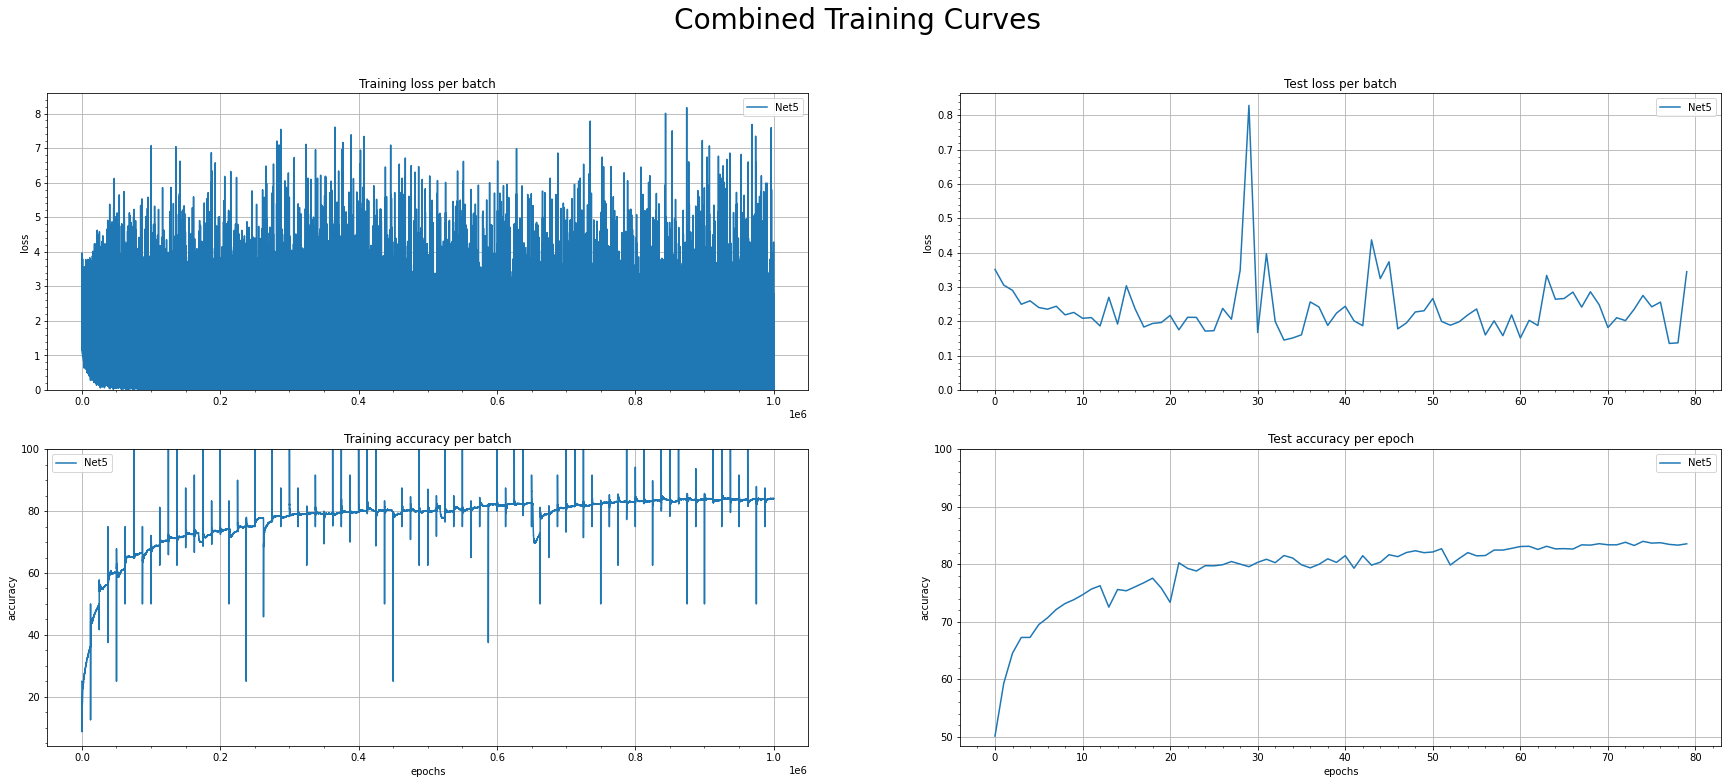

In [10]:
training_curves(history)

In [14]:
# Input parameters for the model
EPOCHS = 40
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run model for first 20 epochs with high rate, and half it thereafter
model = Net(args).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Net5_lr1'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.2534370422363281 Batch_id=12499 Accuracy=38.68: 100%|██████████| 12500/12500 [00:47<00:00, 261.72it/s] 

length of Average loss 12500, length of Average accuracy 12500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3445, Accuracy: 5393/10000 (53.93%)

EPOCH: 2


Loss=0.4562018811702728 Batch_id=12499 Accuracy=53.18: 100%|██████████| 12500/12500 [00:47<00:00, 262.11it/s] 

length of Average loss 25000, length of Average accuracy 25000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2621, Accuracy: 6406/10000 (64.06%)

EPOCH: 3


Loss=2.0629799365997314 Batch_id=12499 Accuracy=59.38: 100%|██████████| 12500/12500 [00:47<00:00, 262.06it/s] 

length of Average loss 37500, length of Average accuracy 37500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2498, Accuracy: 6506/10000 (65.06%)

EPOCH: 4


Loss=0.0882272720336914 Batch_id=12499 Accuracy=62.81: 100%|██████████| 12500/12500 [00:48<00:00, 259.92it/s]  

length of Average loss 50000, length of Average accuracy 50000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2216, Accuracy: 6975/10000 (69.75%)

EPOCH: 5


Loss=1.0496842861175537 Batch_id=12499 Accuracy=65.15: 100%|██████████| 12500/12500 [00:47<00:00, 262.64it/s]  


length of Average loss 62500, length of Average accuracy 62500

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2047, Accuracy: 7205/10000 (72.05%)

EPOCH: 6


Loss=0.8030381798744202 Batch_id=12499 Accuracy=66.28: 100%|██████████| 12500/12500 [00:47<00:00, 261.34it/s]  

length of Average loss 75000, length of Average accuracy 75000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2127, Accuracy: 7045/10000 (70.45%)

EPOCH: 7


Loss=0.8614712357521057 Batch_id=12499 Accuracy=68.06: 100%|██████████| 12500/12500 [00:48<00:00, 260.33it/s]  

length of Average loss 87500, length of Average accuracy 87500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2103, Accuracy: 7189/10000 (71.89%)

EPOCH: 8


Loss=1.1719878911972046 Batch_id=12499 Accuracy=69.67: 100%|██████████| 12500/12500 [00:47<00:00, 262.82it/s]  

length of Average loss 100000, length of Average accuracy 100000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1907, Accuracy: 7477/10000 (74.77%)

EPOCH: 9


Loss=0.849645733833313 Batch_id=12499 Accuracy=70.49: 100%|██████████| 12500/12500 [00:47<00:00, 262.16it/s]   


length of Average loss 112500, length of Average accuracy 112500

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1982, Accuracy: 7440/10000 (74.40%)

EPOCH: 10


Loss=0.5057377219200134 Batch_id=12499 Accuracy=71.24: 100%|██████████| 12500/12500 [00:47<00:00, 264.89it/s]  

length of Average loss 125000, length of Average accuracy 125000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1994, Accuracy: 7480/10000 (74.80%)

EPOCH: 11


Loss=1.3425648212432861 Batch_id=12499 Accuracy=74.46: 100%|██████████| 12500/12500 [00:47<00:00, 263.45it/s]  


length of Average loss 137500, length of Average accuracy 137500

learning rate 0.005


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1739, Accuracy: 7720/10000 (77.20%)

EPOCH: 12


Loss=0.8971060514450073 Batch_id=12499 Accuracy=75.24: 100%|██████████| 12500/12500 [00:47<00:00, 263.08it/s]  


length of Average loss 150000, length of Average accuracy 150000

learning rate 0.005


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1770, Accuracy: 7783/10000 (77.83%)

EPOCH: 13


Loss=0.6811035871505737 Batch_id=12499 Accuracy=75.78: 100%|██████████| 12500/12500 [00:47<00:00, 263.60it/s]   

length of Average loss 162500, length of Average accuracy 162500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1639, Accuracy: 7809/10000 (78.09%)

EPOCH: 14


Loss=1.931561827659607 Batch_id=12499 Accuracy=75.85: 100%|██████████| 12500/12500 [00:47<00:00, 261.79it/s]   

length of Average loss 175000, length of Average accuracy 175000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1817, Accuracy: 7685/10000 (76.85%)

EPOCH: 15


Loss=0.9714949727058411 Batch_id=12499 Accuracy=75.96: 100%|██████████| 12500/12500 [00:47<00:00, 261.83it/s]   

length of Average loss 187500, length of Average accuracy 187500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1644, Accuracy: 7818/10000 (78.18%)

EPOCH: 16


Loss=0.8969262838363647 Batch_id=12499 Accuracy=76.61: 100%|██████████| 12500/12500 [00:47<00:00, 264.71it/s]  

length of Average loss 200000, length of Average accuracy 200000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1658, Accuracy: 7928/10000 (79.28%)

EPOCH: 17


Loss=0.04505854845046997 Batch_id=12499 Accuracy=76.77: 100%|██████████| 12500/12500 [00:47<00:00, 261.74it/s]  

length of Average loss 212500, length of Average accuracy 212500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1609, Accuracy: 7921/10000 (79.21%)

EPOCH: 18


Loss=2.9317586421966553 Batch_id=12499 Accuracy=77.44: 100%|██████████| 12500/12500 [00:47<00:00, 261.63it/s]   

length of Average loss 225000, length of Average accuracy 225000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1598, Accuracy: 7913/10000 (79.13%)

EPOCH: 19


Loss=0.5951747298240662 Batch_id=12499 Accuracy=77.54: 100%|██████████| 12500/12500 [00:47<00:00, 263.39it/s]  

length of Average loss 237500, length of Average accuracy 237500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1600, Accuracy: 7998/10000 (79.98%)

EPOCH: 20


Loss=0.7953029274940491 Batch_id=12499 Accuracy=77.81: 100%|██████████| 12500/12500 [00:47<00:00, 260.46it/s]   

length of Average loss 250000, length of Average accuracy 250000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1661, Accuracy: 7984/10000 (79.84%)

EPOCH: 21


Loss=0.5035605430603027 Batch_id=12499 Accuracy=78.84: 100%|██████████| 12500/12500 [00:47<00:00, 262.49it/s]   

length of Average loss 262500, length of Average accuracy 262500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1543, Accuracy: 8028/10000 (80.28%)

EPOCH: 22


Loss=0.90822434425354 Batch_id=12499 Accuracy=79.61: 100%|██████████| 12500/12500 [00:47<00:00, 261.61it/s]    

length of Average loss 275000, length of Average accuracy 275000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1457, Accuracy: 8134/10000 (81.34%)

EPOCH: 23


Loss=0.7851781845092773 Batch_id=12499 Accuracy=79.65: 100%|██████████| 12500/12500 [00:47<00:00, 262.19it/s]   

length of Average loss 287500, length of Average accuracy 287500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1527, Accuracy: 8063/10000 (80.63%)

EPOCH: 24


Loss=0.3391146659851074 Batch_id=12499 Accuracy=79.75: 100%|██████████| 12500/12500 [00:47<00:00, 263.61it/s]  

length of Average loss 300000, length of Average accuracy 300000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1422, Accuracy: 8103/10000 (81.03%)

EPOCH: 25


Loss=0.8743066787719727 Batch_id=12499 Accuracy=80.30: 100%|██████████| 12500/12500 [00:47<00:00, 261.70it/s]   

length of Average loss 312500, length of Average accuracy 312500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1497, Accuracy: 8075/10000 (80.75%)

EPOCH: 26


Loss=0.9659347534179688 Batch_id=12499 Accuracy=80.03: 100%|██████████| 12500/12500 [00:48<00:00, 259.96it/s]  

length of Average loss 325000, length of Average accuracy 325000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1478, Accuracy: 8097/10000 (80.97%)

EPOCH: 27


Loss=0.706671953201294 Batch_id=12499 Accuracy=80.09: 100%|██████████| 12500/12500 [00:47<00:00, 261.84it/s]    

length of Average loss 337500, length of Average accuracy 337500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1639, Accuracy: 8084/10000 (80.84%)

EPOCH: 28


Loss=0.021701231598854065 Batch_id=12499 Accuracy=80.36: 100%|██████████| 12500/12500 [00:47<00:00, 262.58it/s] 

length of Average loss 350000, length of Average accuracy 350000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1519, Accuracy: 8094/10000 (80.94%)

EPOCH: 29


Loss=0.3049508333206177 Batch_id=12499 Accuracy=80.41: 100%|██████████| 12500/12500 [00:47<00:00, 262.13it/s]   

length of Average loss 362500, length of Average accuracy 362500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1753, Accuracy: 8057/10000 (80.57%)

EPOCH: 30


Loss=0.15142104029655457 Batch_id=12499 Accuracy=80.80: 100%|██████████| 12500/12500 [00:47<00:00, 263.28it/s]  

length of Average loss 375000, length of Average accuracy 375000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1453, Accuracy: 8106/10000 (81.06%)

EPOCH: 31


Loss=0.4921250641345978 Batch_id=12499 Accuracy=81.14: 100%|██████████| 12500/12500 [00:48<00:00, 256.85it/s]   

length of Average loss 387500, length of Average accuracy 387500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1520, Accuracy: 8150/10000 (81.50%)

EPOCH: 32


Loss=1.9693315029144287 Batch_id=12499 Accuracy=81.44: 100%|██████████| 12500/12500 [00:50<00:00, 248.88it/s]   

length of Average loss 400000, length of Average accuracy 400000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1473, Accuracy: 8239/10000 (82.39%)

EPOCH: 33


Loss=0.11549894511699677 Batch_id=12499 Accuracy=81.67: 100%|██████████| 12500/12500 [00:50<00:00, 247.47it/s]  

length of Average loss 412500, length of Average accuracy 412500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1504, Accuracy: 8202/10000 (82.02%)

EPOCH: 34


Loss=0.0899486094713211 Batch_id=12499 Accuracy=81.75: 100%|██████████| 12500/12500 [00:49<00:00, 251.09it/s]   

length of Average loss 425000, length of Average accuracy 425000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1387, Accuracy: 8208/10000 (82.08%)

EPOCH: 35


Loss=0.4468074142932892 Batch_id=12499 Accuracy=81.64: 100%|██████████| 12500/12500 [00:48<00:00, 259.83it/s]   

length of Average loss 437500, length of Average accuracy 437500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1330, Accuracy: 8226/10000 (82.26%)

EPOCH: 36


Loss=0.6961657404899597 Batch_id=12499 Accuracy=81.66: 100%|██████████| 12500/12500 [00:47<00:00, 261.04it/s]   

length of Average loss 450000, length of Average accuracy 450000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1582, Accuracy: 8155/10000 (81.55%)

EPOCH: 37


Loss=1.798656940460205 Batch_id=12499 Accuracy=81.83: 100%|██████████| 12500/12500 [00:47<00:00, 261.84it/s]    


length of Average loss 462500, length of Average accuracy 462500

learning rate 0.00125


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1334, Accuracy: 8263/10000 (82.63%)

EPOCH: 38


Loss=1.2776223421096802 Batch_id=12499 Accuracy=81.74: 100%|██████████| 12500/12500 [00:47<00:00, 262.76it/s]   

length of Average loss 475000, length of Average accuracy 475000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1547, Accuracy: 8174/10000 (81.74%)

EPOCH: 39


Loss=1.1600286960601807 Batch_id=12499 Accuracy=81.92: 100%|██████████| 12500/12500 [00:47<00:00, 262.33it/s]   

length of Average loss 487500, length of Average accuracy 487500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.1392, Accuracy: 8282/10000 (82.82%)

EPOCH: 40


Loss=0.20151042938232422 Batch_id=12499 Accuracy=82.25: 100%|██████████| 12500/12500 [00:47<00:00, 262.99it/s]  

length of Average loss 500000, length of Average accuracy 500000

learning rate 0.00125


Test set: Average loss: 0.1346, Accuracy: 8246/10000 (82.46%)



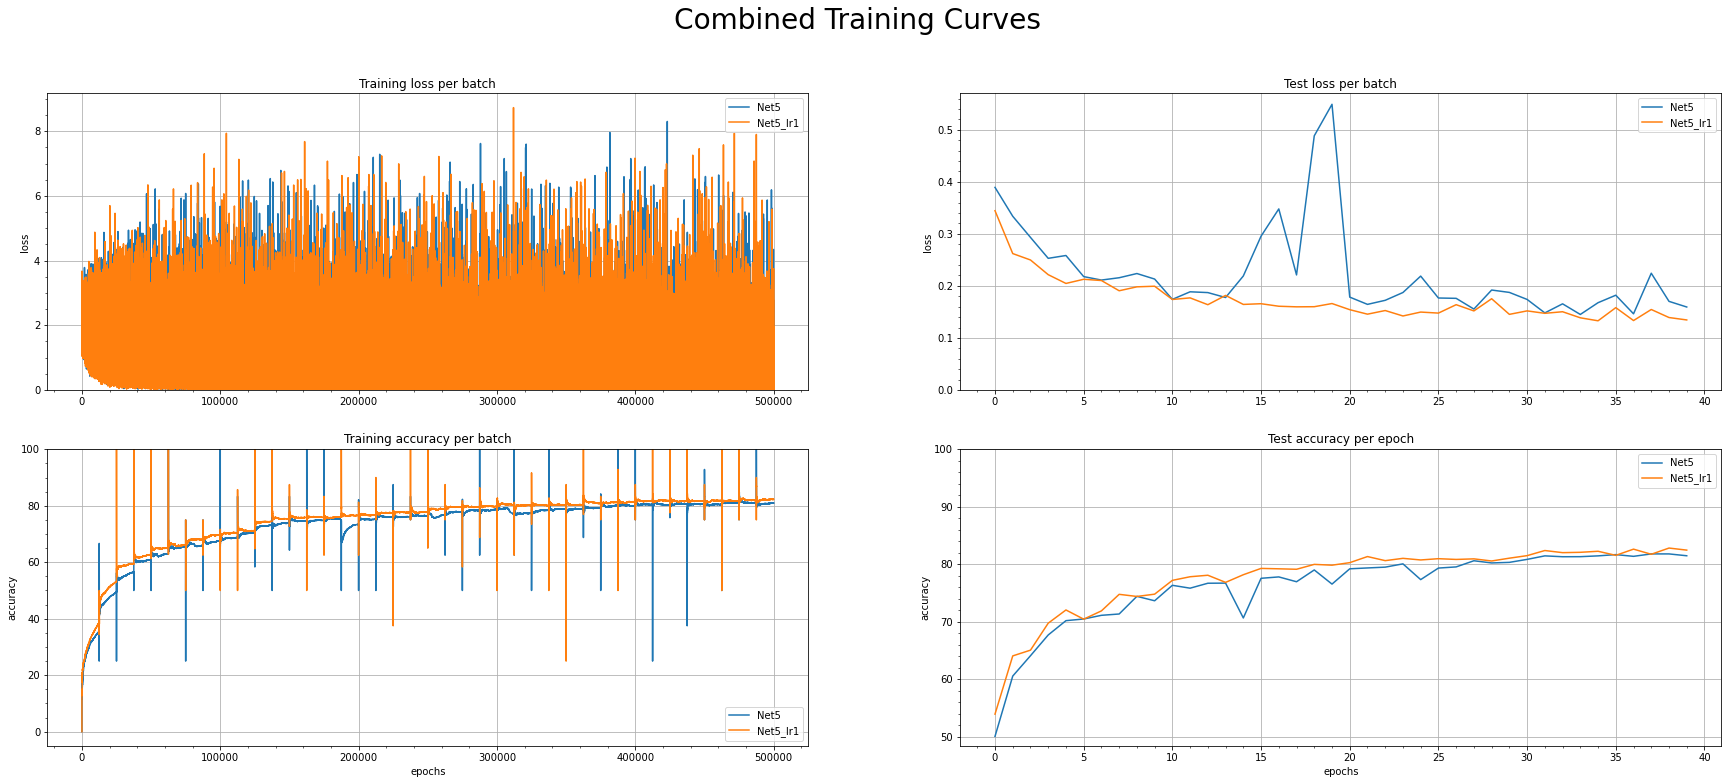

In [15]:
training_curves(history)

In [8]:
temp = Net1(args).to(device)
summary(temp, (3, 32, 32),)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
             ReLU-14           [-1, 32,

In [9]:
# Input parameters for the model
EPOCHS = 80
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run model for first 20 epochs with high rate, and half it thereafter
model = Net(args).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Net1'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1


/home/lebeast/miniconda3/envs/pytorch19/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Loss=1.3604810237884521 Batch_id=12499 Accuracy=37.26: 100%|██████████| 12500/12500 [00:49<00:00, 253.91it/s] 

length of Average loss 12500, length of Average accuracy 12500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3916, Accuracy: 5265/10000 (52.65%)

EPOCH: 2


Loss=1.760800838470459 Batch_id=12499 Accuracy=50.76: 100%|██████████| 12500/12500 [00:49<00:00, 252.04it/s]  

length of Average loss 25000, length of Average accuracy 25000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3357, Accuracy: 6106/10000 (61.06%)

EPOCH: 3


Loss=0.7818239331245422 Batch_id=12499 Accuracy=57.58: 100%|██████████| 12500/12500 [00:49<00:00, 254.79it/s] 

length of Average loss 37500, length of Average accuracy 37500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.2689, Accuracy: 6524/10000 (65.24%)

EPOCH: 4


Loss=2.2557430267333984 Batch_id=12499 Accuracy=61.96: 100%|██████████| 12500/12500 [00:47<00:00, 264.82it/s] 

length of Average loss 50000, length of Average accuracy 50000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3028, Accuracy: 6844/10000 (68.44%)

EPOCH: 5


Loss=0.420420378446579 Batch_id=12499 Accuracy=64.48: 100%|██████████| 12500/12500 [00:47<00:00, 262.58it/s]  

length of Average loss 62500, length of Average accuracy 62500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.3006, Accuracy: 6966/10000 (69.66%)

EPOCH: 6


Loss=2.523698091506958 Batch_id=1920 Accuracy=65.98:  15%|█▌        | 1921/12500 [00:07<00:42, 248.48it/s]  


KeyboardInterrupt: 

In [ ]:
training_curves(history)